Compute EEG residuals from learned encoders, dropping out relevant word-level features (surprisal and frequency).

For word stimuli with matched cohorts (or at least matched likelihoods), find instances which are recognized early vs. late due to context.
Bin and compare residual time series between bins.

In [1]:
from argparse import ArgumentParser, Namespace
from collections import defaultdict
from copy import deepcopy
from itertools import product
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append(str(Path(".").resolve().parent.parent))
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
import berp.models.reindexing_regression as rr
from berp.viz.trf import trf_to_dataframe, plot_trf_coefficients

In [5]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [6]:
SAVE_FIGURES = True
figure_path = Path(".")

In [7]:
p = ArgumentParser()
p.add_argument("model_base_dir", type=Path, help="Load pipeline and dataset from this base dir")
p.add_argument("subjects", type=str, nargs="+")
p.add_argument("stories", type=str, nargs="+")
p.add_argument("run_names", type=str, nargs="+")

_StoreAction(option_strings=[], dest='run_names', nargs='+', const=None, default=None, type=<class 'str'>, choices=None, required=True, help=None, metavar=None)

In [8]:
if IS_INTERACTIVE:
    args = Namespace(
        # model_base_dir=Path("../../work/2b/cda8e6c76a9235517148309c3afb33/"),
        model_base_dir=Path("../../work/b6/f943409afa218eade300702170b1d1/"),
        subjects=["average"],
        stories=["DKZ_1", "DKZ_2"],
        run_names=["berp-fixed-20221031"],)
else:
    args = p.parse_args()

In [9]:
epoch_tmin, epoch_tmax = -12/128, 96/128

## Load results

In [10]:
# Load pipelines.
if len(args.run_names) > 1:
    raise NotImplementedError("not yet supporting multiple pipelines")

pipes = []
for run in args.run_names:
    # HACK magic string
    pipeline_path = args.model_base_dir / run / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        print(f"Missing pipeline at {pipeline_path}")

    with pipeline_path.open("rb") as f:
        pipes.append(pickle.load(f))
        
    # TODO shape checks etc.

# TODO support more than one pipeline
pipe = pipes[0]

In [11]:
# Load datasets.
target_sensors = ["C1", "Cz", "C2", "CP1", "CPz", "CP2"]
ds = {}
stimulus_paths = {story: args.model_base_dir / f"{story}.pkl" for story in args.stories}
combs = list(product(args.stories, args.subjects))
for story, subject in tqdm(combs):
    ds_path = args.model_base_dir / f"{story}.{subject}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject] = load_eeg_dataset(
        [ds_path], "biosemi64", subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=True, normalize_X_variable=True, normalize_Y=True).datasets[0]

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
sample_ds = next(iter(ds.values()))

## Preprocessing

In [13]:
encoders = {subject: pipe.encoders_[subject] for subject in args.subjects}

In [14]:
feature_names = sample_ds.ts_feature_names + sample_ds.variable_feature_names
feature_names

['binned acoustical edges >100Hz_0',
 'binned acoustical edges >100Hz_1',
 'binned acoustical edges >100Hz_2',
 'binned acoustical edges >100Hz_3',
 'binned acoustical edges >100Hz_4',
 'binned acoustical edges >100Hz_5',
 'binned acoustical edges >100Hz_6',
 'binned acoustical edges >100Hz_7',
 'phoneme entropy_0',
 'phoneme onsets_0',
 'phoneme surprisal_0',
 'binned spectrogram >100Hz_0',
 'binned spectrogram >100Hz_1',
 'binned spectrogram >100Hz_2',
 'binned spectrogram >100Hz_3',
 'binned spectrogram >100Hz_4',
 'binned spectrogram >100Hz_5',
 'binned spectrogram >100Hz_6',
 'binned spectrogram >100Hz_7',
 'word onsets_0',
 'recognition_onset',
 'word_frequency',
 'word_surprisal']

In [15]:
params = pipe.params[0]

p_candidates, recognition_points, recognition_times = {}, {}, {}
for (story, subject), ds_i in tqdm(ds.items()):
    if story in p_candidates:
        # Already computed.
        continue

    p_candidates[story] = rr.predictive_model(
        ds_i.p_candidates, ds_i.candidate_phonemes,
        confusion=params.confusion,
        lambda_=params.lambda_,
        return_gt_only=False)
    recognition_points[story], recognition_times[story] = \
        pipe.get_recognition_times(ds_i, pipe.params[0])

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
# Estimate median phoneme onset time
# Sloppily estimate phoneme onset averages, just within one dataset
ph_ons = sample_ds.phoneme_onsets.clone()
ph_ons[torch.arange(ph_ons.shape[1]).unsqueeze(0) >= sample_ds.word_lengths.unsqueeze(1)] = np.nan
ph_ons.nanmedian(dim=0)[0]

tensor([0.0000, 0.0700, 0.1600, 0.2700, 0.3400, 0.4100, 0.4800, 0.5500, 0.5900,
        0.6800, 0.7600, 0.8500, 0.8900, 0.9300])

## Compute residual time series

In [17]:
def ablate_encoder(encoder):
    """
    Return a copied encoder with ablated variable-onset coefficients.
    """
    ret = deepcopy(encoder)
    # Zero out variable-onset features.
    variable_onset_feature_start = sample_ds.n_ts_features
    ret.coef_[variable_onset_feature_start:, :, :] = 0.
    return ret

ablated_encoders = {subject: ablate_encoder(encoder) for subject, encoder in encoders.items()}

In [18]:
Y, Y_resid, Y_resid_ablated = {}, {}, {}
for (story, subject), ds_i in tqdm(ds.items()):
    pipe.prime(ds_i)
    
    encoder = encoders[subject]
    ablated_encoder = ablated_encoders[subject]
    
    design_matrix, _ = pipe.pre_transform(ds_i)
    Y_pred = encoder.predict(design_matrix)
    Y_pred_ablated = ablated_encoder.predict(design_matrix)
    
    Y[story, subject] = ds_i.Y
    Y_resid[story, subject] = ds_i.Y - Y_pred
    Y_resid_ablated[story, subject] = ds_i.Y - Y_pred_ablated
    
    mse = (Y_resid[story, subject] ** 2).sum(axis=1).mean()
    mse_ablated = (Y_resid_ablated[story, subject] ** 2).sum(axis=1).mean()
    print(story, subject, mse, mse_ablated, mse - mse_ablated)

  0%|          | 0/2 [00:00<?, ?it/s]

DKZ_1 average tensor(5.9093) tensor(5.9113) tensor(-0.0019)
DKZ_2 average tensor(5.8152) tensor(5.8157) tensor(-0.0005)


In [26]:
# # Comparison case: what happens when we ablate word onset feature?
# feature_names = ds.ts_feature_names + ds.variable_feature_names
# ablated_encoder2 = deepcopy(encoder)
# ablated_encoder2.coef_[feature_names.index("word onsets_0"), :, :] = 0.

# Y_pred_ablated2 = ablated_encoder2.predict(design_matrix)
# Y_resid_ablated2 = ds.Y - Y_pred_ablated2
# mse_ablated2 = (Y_resid_ablated2 ** 2).sum(axis=1).mean()
# mse_ablated2, mse - mse_ablated2

## Visualize epoched data

In [21]:
def make_word_epochs(word_idxs, word_onsets, phoneme_onsets,
                     recognition_points, recognition_times,
                     eeg_data, sample_rate,
                     index_by_recognition=False, baseline=True):
    tmin, tmax = epoch_tmin, epoch_tmax
    baseline_window = (-12/128, 0.0)
    # DEV for now assume things cut cleanly w.r.t. sample rate
    assert int(tmin * sample_rate) == tmin * sample_rate
    assert int(tmax * sample_rate) == tmax * sample_rate
    for edge in baseline_window:
        assert int(edge * sample_rate) == edge * sample_rate
    epoch_n_samples = int((tmax - tmin) * sample_rate)
    # Compute baseline sample indices relative to start of epoch window
    baseline_samp_window = (int((baseline_window[0] - tmin) * sample_rate),
                            int((baseline_window[1] - tmin) * sample_rate))

    if index_by_recognition:
        # t=0 <=> recognition time
        onsets = recognition_times
    else:
        # t=0 <=> word onset (first phoneme onset)
        onsets = word_onsets[word_idxs]
    onsets_samp = (onsets * sample_rate).long()
    
    epoch_shift_left = int(tmin * sample_rate)
    epoch_shift_right = int(tmax * sample_rate)

    # Epoch EEG data.
    epochs = np.empty((len(word_idxs), epoch_n_samples, len(target_sensors)))
    for i, samp_i in enumerate(tqdm(onsets_samp)):
        epoch_data = eeg_data[samp_i + epoch_shift_left:samp_i + epoch_shift_right].clone()

        # Baseline
        if baseline:
            baseline_left, baseline_right = baseline_samp_window
            epoch_data -= epoch_data[baseline_left:baseline_right].mean(axis=0)
        
        if epoch_data.shape[0] < epoch_n_samples:
            # pad with NaNs
            epoch_data = np.concatenate(
                [epoch_data,
                 np.empty((epoch_n_samples - epoch_data.shape[0], len(target_sensors))) * np.nan],
                axis=0)

        epochs[i] = epoch_data
        
    # Get word recognition points for each target word token.
    our_recognition_points = recognition_points[word_idxs].numpy()
    our_recognition_times = recognition_times[word_idxs].numpy()

    # Convert to DataFrame.
    epochs_df = []
    for i, sample, sensor in np.ndindex(*epochs.shape):
        epochs_df.append((i, sample, target_sensors[sensor], epochs[i, sample, sensor],
                          our_recognition_points[i], our_recognition_times[i]))
    epochs_df = pd.DataFrame(epochs_df, columns=["epoch", "sample", "sensor", "value",
                                                 "recognition_point", "recognition_time"])
    epochs_df["epoch_time"] = epochs_df["sample"] / sample_rate + tmin
    epochs_df = epochs_df.set_index(["epoch", "sample", "sensor"])
    
    return epochs_df

In [22]:
epoch_dfs = {}
for (story, subject), ds_i in tqdm(ds.items()):
    eeg_data = ds_i.Y
    word_ids = torch.arange(len(ds_i.word_lengths))
    
    epoch_dfs[story, subject] = make_word_epochs(
        word_ids, ds_i.word_onsets, ds_i.phoneme_onsets,
        recognition_points[story], recognition_times[story],
        eeg_data, ds_i.sample_rate,
        baseline=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [23]:
epoch_df = pd.concat(epoch_dfs, names=["story", "subject", "epoch", "sample", "sensor"])

### Average word response

<AxesSubplot:xlabel='epoch_time', ylabel='value'>

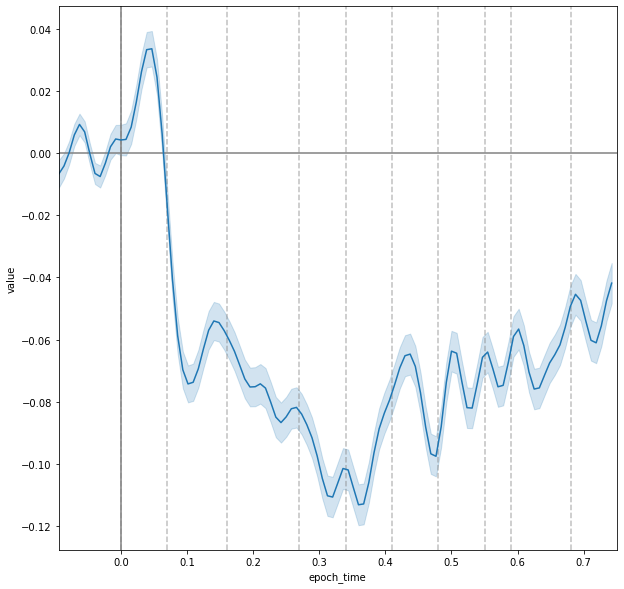

In [24]:
plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")
plt.xlim((epoch_tmin, epoch_tmax))
for phoneme_onset_i in ph_ons.nanmedian(axis=0)[0].numpy():
    if phoneme_onset_i > epoch_tmax:
        continue
    plt.axvline(phoneme_onset_i, color="gray", linestyle="--", alpha=0.5)

sns.lineplot(data=epoch_df, x="epoch_time", y="value", errorbar="se")

In [25]:
# cohort_epochs = make_word_epochs(cohort_word_ids, Y_resid_ablated)

# plt.subplots(figsize=(10, 10))
# sns.lineplot(data=cohort_epochs.reset_index(), x="epoch_time", y="value", hue="recognition_point", ci=None)
# plt.axvline(0)

## Visualize recognition point

In [37]:
# Get recognition points by time and combine into single figure.
recognition_points_pooled = []
recognition_times_pooled = []
for story, recognition_points_i in recognition_points.items():
    # Find a dataset for this story so we can look up word/phoneme onsets.
    ds_i = next(iter(ds_j for (story_j, subject_j), ds_j in ds.items()
                     if story == story_j))
    
    # Compute recognition times relative to word onset
    recognition_times_i = recognition_times[story] - ds_i.word_onsets
    recognition_points_pooled.extend(recognition_points_i.numpy())
    recognition_times_pooled.extend(recognition_times_i.numpy())

In [38]:
rec_df = pd.DataFrame({"Recognition point": np.array(recognition_points_pooled),
                       "Recognition time": recognition_times_pooled})

In [39]:
rec_df["Recognition point"].value_counts()

2     1523
1     1003
3      904
4      417
0      191
5      181
6       60
7       21
8        5
9        2
10       1
Name: Recognition point, dtype: int64

([<matplotlib.axis.XTick at 0x2b01e8900ee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

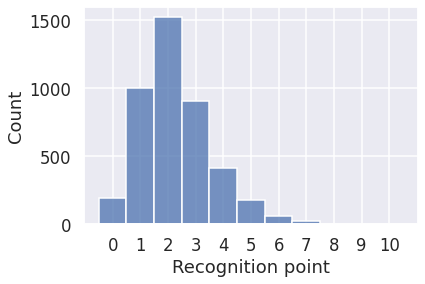

In [40]:
sns.set("talk")
# plt.subplots(figsize=(12, 4))
sns.histplot(data=rec_df, x="Recognition point", bins=11, discrete=True)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

<AxesSubplot:xlabel='Recognition time', ylabel='Density'>

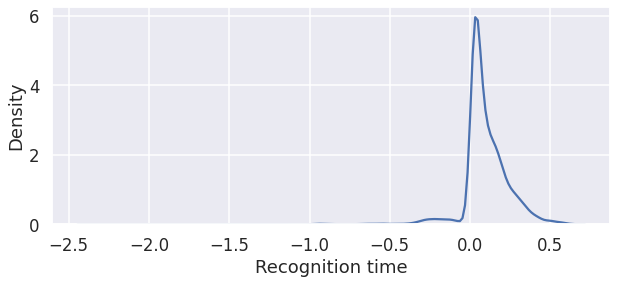

In [43]:
plt.subplots(figsize=(10, 4))
# plt.xlim((0, epoch_tmax))
# plt.ylim((-0.1, 6.5))
sns.kdeplot(data=rec_df, x="Recognition time")

<AxesSubplot:xlabel='Recognition time'>

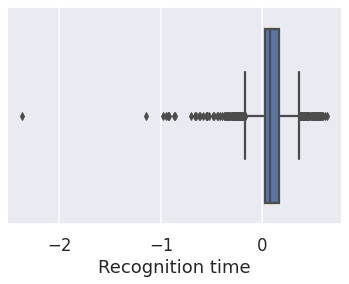

In [44]:
sns.boxplot(data=rec_df, x="Recognition time")

## Epoch by recognition point

In [45]:
rec_epoch_dfs = {}
for recognition_point in tqdm([0, 1, 2, 3]):
    for story, recognition_points_ds in recognition_points.items():
        recognition_times_ds = recognition_times[story]

        word_ids = torch.where(recognition_points_ds == recognition_point)[0]
        
        for subject in encoders.keys():
            ds_i = ds[story, subject]
            eeg_data = Y_resid_ablated[story, subject]
        
            rec_epoch_dfs[(story, subject, recognition_point)] = make_word_epochs(
                word_ids, ds_i.word_onsets, ds_i.phoneme_onsets,
                recognition_points_ds, recognition_times_ds,
                eeg_data, ds_i.sample_rate)

            print(recognition_point, len(rec_epoch_dfs[(story, subject, recognition_point)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0 64800


  0%|          | 0/91 [00:00<?, ?it/s]

0 58968


  0%|          | 0/531 [00:00<?, ?it/s]

1 344088


  0%|          | 0/472 [00:00<?, ?it/s]

1 305856


  0%|          | 0/757 [00:00<?, ?it/s]

2 490536


  0%|          | 0/766 [00:00<?, ?it/s]

2 496368


  0%|          | 0/474 [00:00<?, ?it/s]

3 307152


  0%|          | 0/430 [00:00<?, ?it/s]

3 278640


In [50]:
rec_epoch_df_all = pd.concat(rec_epoch_dfs, names=["story", "subject", "rec_point", "epoch", "sample", "sensor"])
rec_epoch_df_all

# Force categorical color scheme
rec_epoch_df_all["recognition_point_str"] = (rec_epoch_df_all.recognition_point).astype(str)
rec_hue_order = [str(x) for x in sorted((rec_epoch_df_all.recognition_point).unique())]

In [51]:
# g = sns.FacetGrid(data=rec_epoch_df_all.reset_index(), row="sensor", height=7, sharey=False)
# g.map(sns.lineplot, "epoch_time", "value", "recognition_point_str").add_legend()

In [52]:
# sns.lineplot(data=rec_epoch_df_all, x="epoch_time", y="value")

In [53]:
# rec_epoch_df_all.groupby(["recognition_point", "sensor"]).apply(lambda xs: xs.iloc[xs.value.argmin()].epoch_time)

### Average residual response

(-0.09375, 0.75)

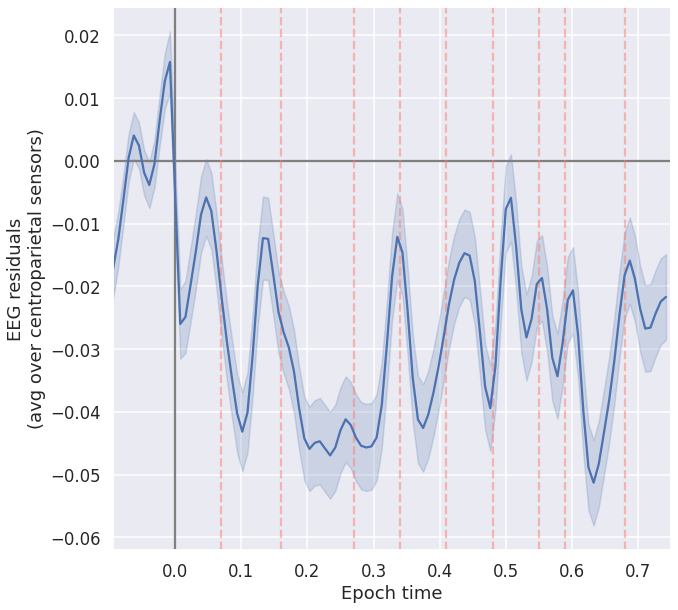

In [54]:
sns.set("talk")
plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")
for phoneme_onset_i in ph_ons.nanmedian(axis=0)[0].numpy():
    if phoneme_onset_i > epoch_tmax or phoneme_onset_i == 0:
        continue
    plt.axvline(phoneme_onset_i, color="salmon", linestyle="--", alpha=0.5)

sns.lineplot(data=rec_epoch_df_all, x="epoch_time", y="value", errorbar="se")
plt.xlabel("Epoch time")
plt.ylabel("EEG residuals\n(avg over centroparietal sensors)")
plt.xlim((epoch_tmin, epoch_tmax))

### Average residual response, grouped by recognition point

<AxesSubplot:xlabel='Recognition time', ylabel='Count'>

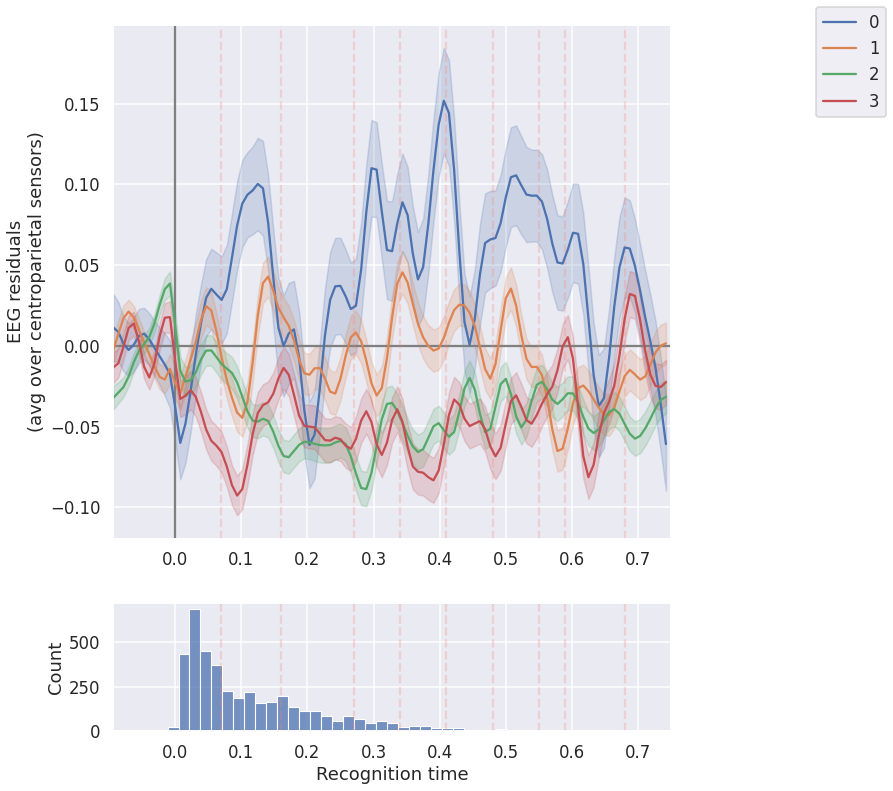

In [56]:
sns.set("talk")

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 13),
                             gridspec_kw={"height_ratios": [4, 1]})

ax1.axhline(0, color="gray")
ax1.axvline(0, color="gray")
for phoneme_onset_i in ph_ons.nanmedian(axis=0)[0].numpy():
    if phoneme_onset_i > epoch_tmax or phoneme_onset_i == 0:
        continue
    ax1.axvline(phoneme_onset_i, color="salmon", linestyle="--", alpha=0.25)
    ax2.axvline(phoneme_onset_i, color="salmon", linestyle="--", alpha=0.25)

sns.lineplot(data=rec_epoch_df_all, x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order,
             errorbar="se",
             ax=ax1)
ax1.set_xlabel("Epoch time")
ax1.set_ylabel("EEG residuals\n(avg over centroparietal sensors)")
ax1.legend(bbox_to_anchor=(1.4, 1.05))
ax1.set_xlim((epoch_tmin, epoch_tmax))
# ax1.set_ylim((-.085, .05))
ax1.xaxis.set_tick_params(which="both", labelbottom=True)

sns.histplot(data=rec_df, x="Recognition time", ax=ax2)

In [ ]:
if SAVE_FIGURES:
    # Render incremental stacking of these lines
    fig_name_template = "residuals_grouped_max{max}.png"
    sns.set("talk")
    
    for max_phon in trange(4):
        to_plot = rec_epoch_df_all[rec_epoch_df_all.recognition_point <= max_phon] \
            .reset_index()
    
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axhline(0, color="gray")
        ax.axvline(0, color="gray")
        
        sns.lineplot(data=to_plot,
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order[:max_phon + 1],
             errorbar="se", ax=ax)
        ax.set_xlabel("Epoch time")
        ax.set_ylabel("EEG residuals\n(avg over centroparietal sensors)")
        # ax.legend(title="Recognition point\n(phoneme)", bbox_to_anchor=(1.4, 1))
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.set_xlim((epoch_tmin, epoch_tmax))
        ax.set_ylim((-.085, .05))
        
        fig.savefig(figure_path / fig_name_template.format(max=max_phon))

### Show epoched data, indexed by recognition point

In [57]:
rec_epoch_reindex_df = {}
for story, recognition_points_ds in tqdm(recognition_points.items()):
    recognition_times_ds = recognition_times[story]

    word_ids = torch.arange(recognition_points_ds.shape[0])
    
    for subject, encoder in encoders.items():
        ds_i = ds[story, subject]
        eeg_data = Y_resid_ablated[story, subject]

        rec_epoch_reindex_df[story, subject] = make_word_epochs(
            word_ids, ds_i.word_onsets, ds_i.phoneme_onsets,
            recognition_points_ds, recognition_times_ds,
            eeg_data, sample_rate=sample_ds.sample_rate,
            index_by_recognition=True,
            baseline=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [58]:
rec_epoch_reindex_df = pd.concat(rec_epoch_reindex_df)
rec_epoch_reindex_df.index.set_names(["story", "subject"], level=[0, 1], inplace=True)
# Force categorical color scheme
rec_epoch_reindex_df["recognition_point_str"] = (rec_epoch_reindex_df.recognition_point).astype(str)
rec_epoch_reindex_df

value  recognition_point  \
story subject epoch sample sensor                                
DKZ_1 average 0     0      C1      2.073337                  5   
                           Cz      2.286435                  5   
                           C2      2.302309                  5   
                           CP1     1.621463                  5   
                           CPz     1.971295                  5   
...                                     ...                ...   
DKZ_2 average 2117  107    Cz      2.137416                  3   
                           C2      1.215625                  3   
                           CP1     0.556790                  3   
                           CPz     1.163876                  3   
                           CP2     0.792527                  3   

                                   recognition_time  epoch_time  \
story subject epoch sample sensor                                 
DKZ_1 average 0     0      C1              1.425000   -0.093750   
                           Cz              1.425000   -0.093750   
                           C2              1.425000   -0.093750   
                           CP1             1.425000   -0.093750   
                           CPz             1.425000   -0.093750   
...                                             ...         ...   
DKZ_2 average 2117  107    Cz            907.179932    0.742188   
                           C2            907.179932    0.742188   
                           CP1           907.179932    0.742188   
                           CPz           907.179932    0.742188   
                           CP2           907.179932    0.742188   

                                  recognition_point_str  
story subject epoch sample sensor                        
DKZ_1 average 0     0      C1                         5  
                           Cz                         5  
                           C2                         5  
                           CP1                        5  
                           CPz                        5  
...                                                 ...  
DKZ_2 average 2117  107    Cz                         3  
                           C2                         3  
                           CP1                        3  
                           CPz                        3  
                           CP2                        3  

[2791584 rows x 5 columns]

(-0.09375, 0.75)

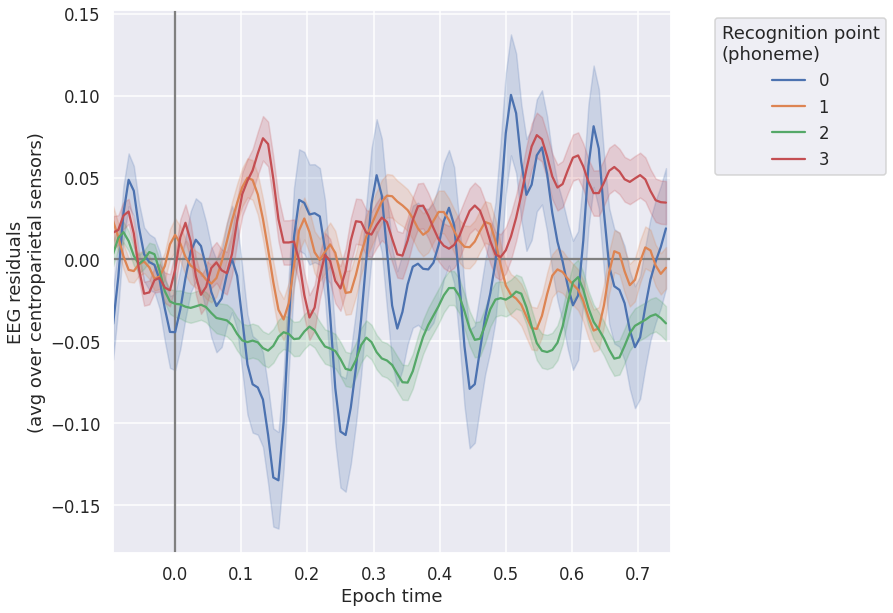

In [59]:
sns.set("talk")

plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")

sns.lineplot(data=rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point < 4].reset_index(),
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order,
             errorbar="se")
plt.xlabel("Epoch time")
plt.ylabel("EEG residuals\n(avg over centroparietal sensors)")
plt.legend(title="Recognition point\n(phoneme)", bbox_to_anchor=(1.4, 1))
plt.xlim((epoch_tmin, epoch_tmax))
# plt.ylim((-.085, .05))

In [ ]:
if SAVE_FIGURES:
    # Render incremental stacking of these lines
    fig_name_template = "residuals_grouped_recpoint_max{max}.png"
    sns.set("talk")
    
    for max_phon in trange(4):
        to_plot = rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point <= max_phon] \
            .reset_index()
    
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axhline(0, color="gray")
        ax.axvline(0, color="gray")
        
        sns.lineplot(data=to_plot,
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order[:max_phon + 1],
             errorbar="se", ax=ax)
        ax.set_xlabel("Epoch time")
        ax.set_ylabel("EEG residuals\n(avg over centroparietal sensors)")
        # ax.legend(title="Recognition point\n(phoneme)", bbox_to_anchor=(1.4, 1))
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.set_xlim((epoch_tmin, epoch_tmax))
        ax.set_ylim((-.085, .05))
        
        fig.savefig(figure_path / fig_name_template.format(max=max_phon))

Text(0, 0.5, 'Raw EEG residuals (avg over centroparietal sensors)')

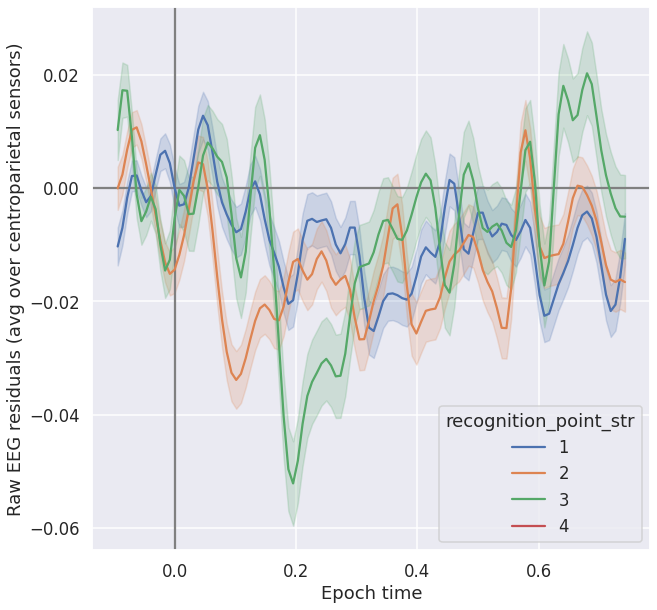

In [63]:
plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")

sns.lineplot(data=rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point < 3].reset_index(),
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order,
             errorbar="se")
plt.xlabel("Epoch time")
plt.ylabel("Raw EEG residuals (avg over centroparietal sensors)")

/tmp/ipykernel_188812/2237174501.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_plot = rec_epoch_reindex_df.loc[(slice(None), slice(None), slice(None), slice(None), sensor_subset)] \


Text(0, 0.5, 'Raw EEG residuals (avg over central sensorsC1, Cz, C2)')

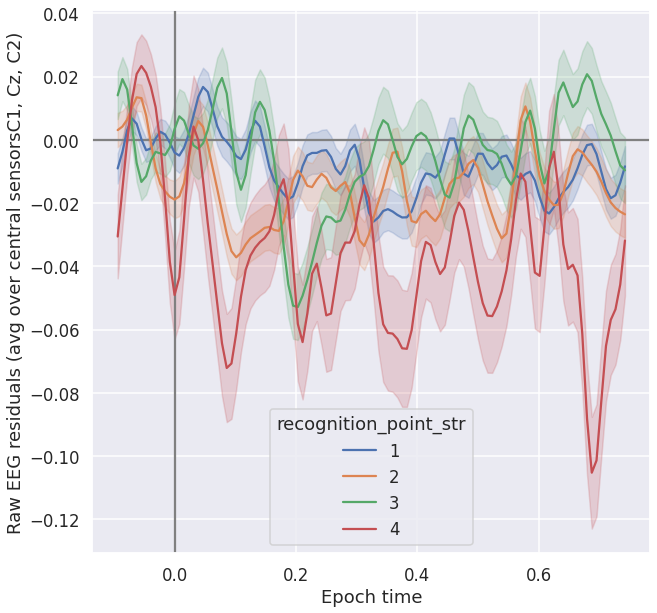

In [64]:
plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")

sensor_subset = ["C1", "Cz", "C2"]
to_plot = rec_epoch_reindex_df.loc[(slice(None), slice(None), slice(None), slice(None), sensor_subset)] \
    [rec_epoch_reindex_df.recognition_point < 4]
sns.lineplot(data=to_plot.reset_index(),
             x="epoch_time", y="value", hue="recognition_point_str", hue_order=rec_hue_order, errorbar="se")
plt.xlabel("Epoch time")
plt.ylabel("Raw EEG residuals (avg over central sensors" + ", ".join(sensor_subset) + ")")

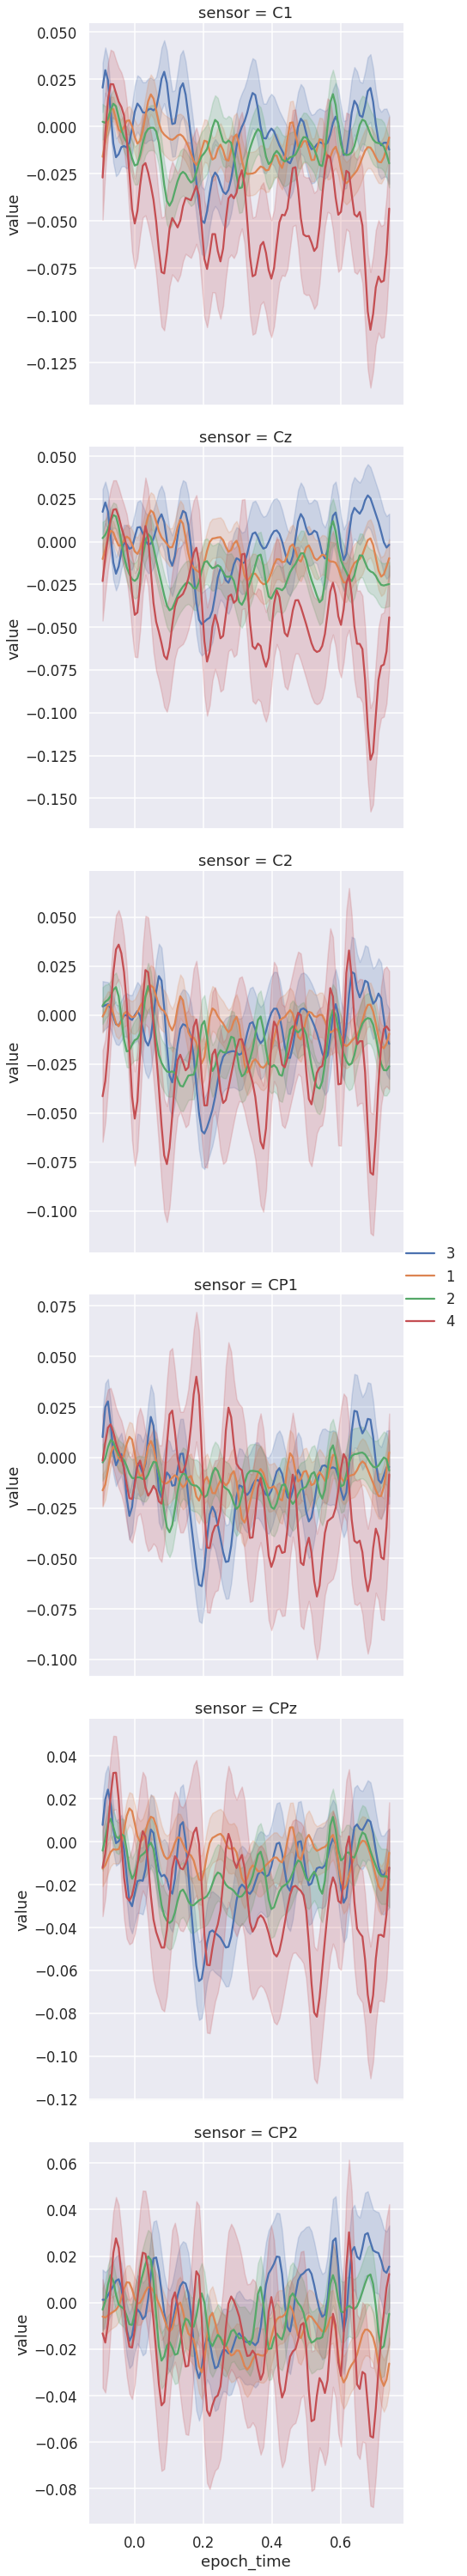

In [65]:
g = sns.FacetGrid(data=rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point < 4].reset_index(),
                  row="sensor", sharey=False, height=7, hue_order=rec_hue_order)
g.map(sns.lineplot, "epoch_time", "value", "recognition_point_str", errorbar="se").add_legend()

## OLD CODE: Stimulus search

Find words with matched cohorts.

In [46]:
gt_word_strs = ["".join(ds.phonemes[phon_idx] for phon_idx in gt_phonemes).rstrip("_")
                for gt_phonemes in tqdm(ds.candidate_phonemes[:, 0, :])]

AttributeError: 'dict' object has no attribute 'candidate_phonemes'

In [ ]:
words_by_cohort = {}
word_ids_by_cohort = {}
for n_phonemes in trange(2, 5):
    words_by_cohort[n_phonemes] = defaultdict(set)
    word_ids_by_cohort[n_phonemes] = defaultdict(list)
    for idx, gt_str in enumerate(gt_word_strs):
        if len(gt_str) < n_phonemes: continue
        
        words_by_cohort[n_phonemes][gt_str[:n_phonemes]].add(gt_str)
        word_ids_by_cohort[n_phonemes][gt_str[:n_phonemes]].append(idx)

In [ ]:
# Find most frequent cohorts.
cohort_sizes = {cohort_length: {cohort: len(word_idxs) for cohort, word_idxs in cohorts.items()}
                for cohort_length, cohorts in word_ids_by_cohort.items()}

k = 10
{length: [(cohort, size) for cohort, size in sorted(cohorts.items(), key=lambda v: -v[1])[:k]]
 for length, cohorts in cohort_sizes.items()}

In [ ]:
# Find cohorts with greatest number of word-type completions.
cohort_uniq_sizes = {cohort_length: {cohort: len(words) for cohort, words in cohorts.items()}
                     for cohort_length, cohorts in words_by_cohort.items()}

k = 10
{length: [(cohort, size) for cohort, size in sorted(cohorts.items(), key=lambda v: -v[1])[:k]]
 for length, cohorts in cohort_uniq_sizes.items()}

In [ ]:
COHORT_SELECTION = "moj"
cohort_word_ids = word_ids_by_cohort[len(COHORT_SELECTION)][COHORT_SELECTION]
cohort_word_ids